In [3]:
%matplotlib inline
import os

import numpy as np
import pandas as pd
# import seaborn as sns

# from nba_utils import draw_3pt_piechart,plot_shot_chart

from IPython.core.display import display, HTML
from IPython.core.magic import register_cell_magic, register_line_cell_magic, register_line_magic
from matplotlib import pyplot as plt
from matplotlib import cm as cm
from matplotlib import colorbar as cbar
from matplotlib import cbook as cbook
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import array, col, count, mean, sum, udf, when
from pyspark.sql.types import DoubleType, IntegerType, StringType, Row
from pyspark.sql.functions import sum, col, udf
from pyspark.sql.functions import year, month, dayofmonth, hour, minute
from pyspark.sql.types import *

import warnings
warnings.filterwarnings("ignore")

# sns.set_style("white")
# sns.set_color_codes()

In [4]:
customSchema = StructType([ 
    StructField("IncidntNum", StringType(), True), 
    StructField("Category", StringType(), True), 
    StructField("Description", StringType(), True), 
    StructField("DayOfWeek", StringType(), True), 
    StructField("Date_str", StringType(), True), 
    StructField("Time_str", StringType(), True), 
    StructField("District", StringType(), True), 
    StructField("Resolution", StringType(), True), 
    StructField("Address", StringType(), True),
    StructField("Longitude", DoubleType(), True),
    StructField("Latitude", DoubleType(), True),
    StructField("Location", StringType(), True),
    StructField("PdId", StringType(), True), ])

In [5]:
crimeDFsource = spark.read.csv('s3a://davidsx/dataSFcrime/', header=True, schema = customSchema)

In [6]:
from pyspark.sql.functions import to_timestamp, concat_ws

crimeDF = crimeDFsource.withColumn("DateTime_str", concat_ws(' ',crimeDFsource.Date_str,crimeDFsource.Time_str))\
.withColumn('Datetime',to_timestamp('DateTime_str', 'MM/dd/yyyy HH:mm').cast(TimestampType()))\

crimeDF = crimeDF.withColumn("Year", year("Datetime")).withColumn("Month", month("Datetime"))\
.withColumn("DayOfMonth",dayofmonth("Datetime")).withColumn("Hour", hour("Datetime"))\
.withColumn("Minute", minute("Datetime"))

crimeDF = crimeDF.drop('Date_str','Time_str','DateTime_str','Resolution','Location','PdId')
crimeDF.printSchema()

root
 |-- IncidntNum: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- DayOfWeek: string (nullable = true)
 |-- District: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Datetime: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayOfMonth: integer (nullable = true)
 |-- Hour: integer (nullable = true)
 |-- Minute: integer (nullable = true)



In [5]:
crimeDF.cache()
sqlContext.registerDataFrameAsTable(crimeDF, 'df')

In [9]:
# get to know about which crime category

count = crimeDF.groupBy('Category').count().orderBy('count')
total = crimeDF.count()

In [7]:
categories = [u'ARSON', u'ASSAULT', u'BAD CHECKS', u'BRIBERY', u'BURGLARY', u'DISORDERLY CONDUCT',\
              u'DRIVING UNDER THE INFLUENCE', u'DRUG/NARCOTIC', u'DRUNKENNESS', u'EMBEZZLEMENT', \
              u'EXTORTION', u'FAMILY OFFENSES', u'FORGERY/COUNTERFEITING', u'FRAUD', u'GAMBLING', \
              u'KIDNAPPING', u'LARCENY/THEFT', u'LIQUOR LAWS', u'LOITERING', u'MISSING PERSON', \
              u'NON-CRIMINAL', u'OTHER OFFENSES', u'PORNOGRAPHY/OBSCENE MAT', u'PROSTITUTION', \
              u'RECOVERED VEHICLE', u'ROBBERY', u'RUNAWAY', u'SECONDARY CODES', \
              u'SEX OFFENSES, FORCIBLE', u'SEX OFFENSES, NON FORCIBLE', u'STOLEN PROPERTY', \
              u'SUICIDE', u'SUSPICIOUS OCC', u'TREA', u'TRESPASS', u'VANDALISM', u'VEHICLE THEFT',\
              u'WARRANTS', u'WEAPON LAWS']

In [8]:
_df = crime_count.orderBy('catCount').toPandas()
categories = _df.Category
n_categories = range(len(categories))
ind = np.arange(len(categories))

<BarContainer object of 39 artists>

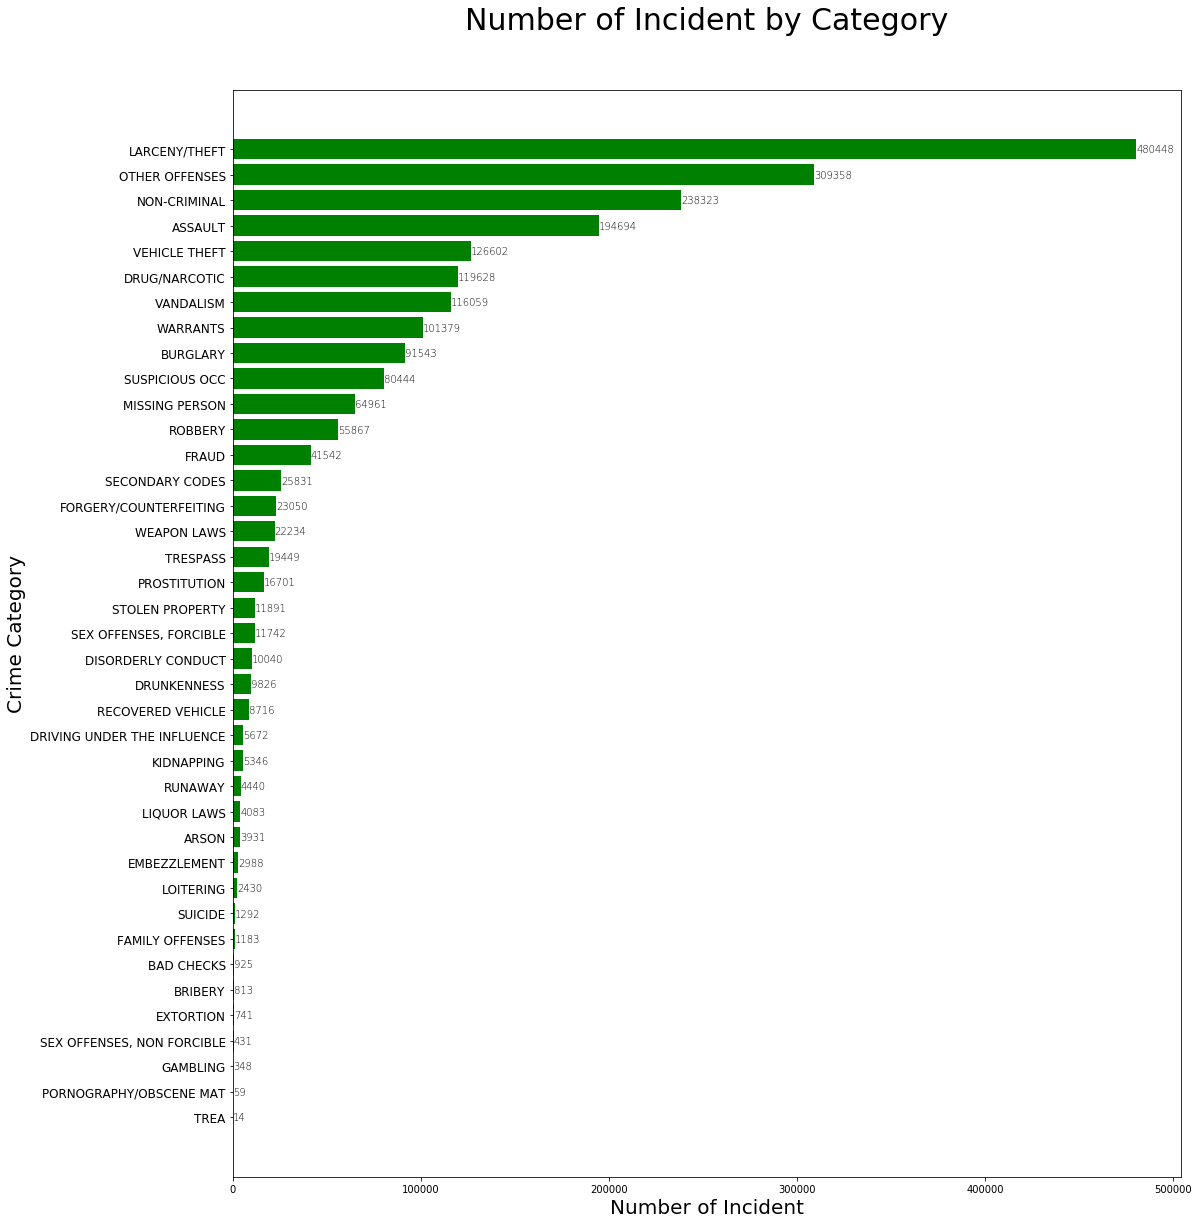

In [9]:
fig = plt.figure(figsize=(17,20))

ax = fig.add_subplot(111)
ax.set_yticklabels(categories, size="12")
ax.set_yticks(ind)
ax.set_ylabel("Crime Category",size="20")
ax.set_xlabel('Number of Incident',size="20")
ax.set_title('Number of Incident by Category', size=30, y=1.05)
for i, v in enumerate(_df.catCount):
    ax.text(v + 3, i - .125, str(v), fontweight='light')

ax.barh(n_categories,_df.catCount, color = 'green')

In [11]:
crime_count.where((col('catCount')>100000)&(~col('Category').isin([u'NON-CRIMINAL', u'OTHER OFFENSES'])))\
.select('Category').rdd.map(lambda x : x[0]).collect()

[u'WARRANTS',
 u'VANDALISM',
 u'DRUG/NARCOTIC',
 u'VEHICLE THEFT',
 u'ASSAULT',
 u'LARCENY/THEFT']

In [12]:
main_crime = \
[u'WARRANTS',
 u'VANDALISM',
 u'DRUG/NARCOTIC',
 u'VEHICLE THEFT',
 u'ASSAULT',
 u'LARCENY/THEFT']

In [2]:
fig = plt.figure(figsize=(17,20))

ax = fig.add_subplot(111)
ax.set_yticklabels(categories, size="12")
ax.set_yticks(ind)
ax.set_ylabel("Crime Category",size="20")
ax.set_xlabel('Number of Incident',size="20")
ax.set_title('Number of Incident by Category', size=30, y=1.05)
for i, v in enumerate(_df.catCount):
    ax.text(v + 3, i - .125, str(v), fontweight='light')

ax.barh(n_categories,_df.catCount, color = 'green')

NameError: name 'plt' is not defined